<a href="https://colab.research.google.com/github/michaeltmk/Captcha_cracker/blob/master/capcha_chacker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Caotcha Chraker**

Aims & Objectives: Recognize captcha from web.

In total there are 384 captcha images, 128 for training set, 128 for dev set, 128 for test set.
For each epoch, 128 more images are generated by captcha simulator and together 256 images are feeded into the model for training. The training will be stopped when the accuracy of dev set is above 0.9.

After training the model, it was tested on the test set and had very good result, the model is fine tuned.

Hence the dev set is moved to the training set. The model is trained again with same setting but a larger training set.


## 1. Install and import necessary packets

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install captcha
!pip install aggdraw

     |████████████████████████████████| 102kB 4.8MB/s 
     |████████████████████████████████| 665kB 6.6MB/s 


In [0]:
from PIL.ImageDraw import Draw
from captcha.image import ImageCaptcha  
import aggdraw
from PIL import ImageFilter
from skimage.io import imread
from skimage.transform import warp
import matplotlib.pylab as plt
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt  
from PIL import Image  
import random
import matplotlib.image as im 

## 2. Captcha simulator and Data processing
Since there are only in total 384 sample, including validation/test set, it is necessary to generate new images using similator.
ImageCaptcha is used for this task, and some methods are modified.

Rewhite ImageCaptcha

In [0]:
#rewhite ImageCaptcha
table  =  []
for  i  in  range( 256 ):
    table.append( i * 1.97 )

def new_create_captcha_image(self, chars, color, background):
    """Create the CAPTCHA image itself.
    :param chars: text to be generated.
    :param color: color of the text.
    :param background: color of the background.
    The color should be a tuple of 3 numbers, such as (0, 255, 255).
    """
    image = Image.new('RGB', (self._width, self._height), background)
    draw = Draw(image)
    #image=create_noise_curve(image)

    def wave(xy):
      xy[:, 1] += random.randint(3,7)*np.sin(2*np.pi*xy[:, 0]/random.randint(64,64))
      return xy

    def crop_image(im):
      im=np.array(im)
      im_gray = np.sum(im,axis=2)
      sum_along_x= np.sum(im_gray,axis=0)
      sum_along_y= np.sum(im_gray,axis=1)
      first_x,last_x = np.nonzero(sum_along_x)[0][0],np.nonzero(sum_along_x)[0][-1]
      first_y,last_y = np.nonzero(sum_along_y)[0][0],np.nonzero(sum_along_y)[0][-1]
      im = im[first_y:last_y+1,first_x:last_x+1]
      return im

    def _draw_character(c):
        font = random.choice(self.truefonts)
        w, h = draw.textsize(c, font=font)
        dx = random.randint(0, 0)              ### 0,4 
        dy = random.randint(0, 0)              ### 0,6 
        im = Image.new('RGBA', (w + dx, h + dy), color=(0,0,0,0))
        Draw(im).text((dx, dy), c, font=font, fill=color)
        #im=im.crop((0,5,im.size[0],im.size[1]))
        im=(warp(im, wave,output_shape=(h+10,w))*255).astype('uint8')
        #im = crop_image(im)
        im = Image.fromarray(im,mode='RGBA')
        # rotate
        im = im.crop(im.getbbox())
        im = im.rotate(random.uniform(-10, 10), Image.BILINEAR, expand=1)
        im = im.resize((40,50))
        im = im.crop(im.getbbox())
        return im

    images = []
    for c in chars:
        if random.random() > 1:
            images.append(_draw_character(" "))
        images.append(_draw_character(c))

    text_width = sum([im.size[0] for im in images])

    width = max(text_width, self._width)
    image = image.resize((width, self._height))

    average = int(text_width / len(chars))
    rand = int(0.25 * average)
    offset = int(average * 0.05)

    for im in images:
        w, h = im.size
        mask = im
        #mask = im.convert('L').point(table)
        image.paste(im, (offset, self._height - h), mask) #self._height - h)), mask)
        offset = offset + w + random.randint(-rand,0)

    image=image.crop((0,0,140,self._height))
    if width != self._width:
        image = image.resize((self._width, self._height))
    return image

def new_generate_image(self, chars):
    """Generate the image of the given characters.
    :param chars: text to be generated.
    """
    background = (255,255,255,0)
    color = (0,0, 0,255)
    im = self.create_captcha_image(chars, color, background)
    #im = im.filter(ImageFilter.SMOOTH)
    #im=im.resize((136,36))
    im=im.resize((self._width, self._height))
    im = create_noise_dots(im, color, width=3, number=30)
    return im

def random_color(start, end, opacity=None):
    red = random.randint(start, end)
    green = random.randint(start, end)
    blue = random.randint(start, end)
    if opacity is None:
        return (red, green, blue)
    return (red, green, blue, opacity)

def create_noise_dots(image, color, width=3, number=30):
    draw = Draw(image)
    w, h = image.size
    while number:
        x1 = random.randint(0, w)
        y1 = random.randint(0, h)
        draw.line(((x1, y1), (x1 - 1, y1 - 1)), fill=color, width=width)
        number -= 1
    return image

def create_noise_curve(image):
    i=100
    while random.random()>0.01 and i>2:
        i-=2
        w, h = image.size
        x1 = random.randint(0, w)       #(0, int(w / 5))
        x2 = random.randint(0, w)    #(w - int(w / 5), w)
        y1 = random.randint(0,h)                      #(int(h / 5), h - int(h / 5))
        y2 = random.randint(0,h)                  #(y1, h - int(h / 5))
        points = [x1, y1, x2, y2]
        end = random.randint(0, 359)      #(160, 200)
        start = random.randint(0, 359)       #(0, 20)
        #Draw(image).arc(points, start, end, fill=color)
        pen=aggdraw.Pen(color=random_color(200,240),
                        width=random.randint(5,15),
                        opacity=random.randint(1,int(100*i/100)))
        d=aggdraw.Draw(image)
        d.arc(points, start, end, pen)
        d.flush()
    return image

ImageCaptcha.generate_image = new_generate_image
ImageCaptcha.create_captcha_image = new_create_captcha_image

Captcha similator and Data processing

In [0]:
class gen_id_card(object):
    def __init__(self):
       
       number = ['3','4','6','8','9']  
       alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']  
       ALPHABET = ['A','B','C','D','E','H','J','K','M','N','P','R','S','T','U','V','W','X','Y']
       self.IMAGE_HEIGHT = 50      #72
       self.IMAGE_WIDTH = 250        #273
       self.font_sizes = (150,150) #for 32X256 18 char:(20,24,26)
       #self.char_set = number
       self.char_set = ALPHABET+number# + alphabet 
       self.len = len(self.char_set)
       self.max_size = 4
       
    def _random_captcha_text(self):
        captcha_size=self.max_size
        char_set=self.char_set
        captcha_text = '' 
        for i in range(captcha_size):  
            x = random.choice(char_set)   
            captcha_text += x
        return captcha_text

    def _convert2gray(self,imag_):
        if len(imag_.shape) > 2:  
            gray = np.mean(imag_, -1)
            return gray  
        else:  
            return imag_ 

    def _get_captcha_text_and_image(self):
        image = ImageCaptcha(width=self.IMAGE_WIDTH, height=self.IMAGE_HEIGHT, font_sizes=self.font_sizes,fonts=['/content/drive/My Drive/Colab Notebooks/OCR/pps/PMingLiU.ttf', '/content/drive/My Drive/Colab Notebooks/OCR/pps/DroidSansMono.ttf'])
        captcha_text = self._random_captcha_text()
        captcha = image.generate_image(captcha_text)
        #char_color =  random.randint(10,100)
        #bg=255
        #captcha = image.create_captcha_image(captcha_text,(char_color, char_color, char_color),(bg,bg,bg))
        captcha_image = captcha
        #captcha_image = Image.open(captcha)
        captcha_image = np.array(captcha_image)
        return captcha_text,captcha_image

    def gen_image(self):
        def wrap_gen_captcha_text_and_image():
            while True:  
                text, image = self._get_captcha_text_and_image()  
                if image.shape == (self.IMAGE_HEIGHT, self.IMAGE_WIDTH, 3):  
                    return text, image
        text, image = wrap_gen_captcha_text_and_image()  
        image = self._convert2gray(image)
        image = self.normalization(image)  
        vec = self.text2vec(text)
        return image, text, vec

    def normalization(self,array):
        mean=np.mean(array)
        SD=np.std(array)
        return (array-mean)/SD

    def _char2vec(self, c):
        vec = np.zeros((self.len))
        for j in range(self.len):
            if self.char_set[j] == c:
                vec[j] = 1
        return vec
    
    def text2vec(self,text):
        vecs=[]
        for c in text:
          vec=self._char2vec(c)
          vecs.append(vec)
        vecs=np.array(vecs).reshape(-1)
        return vecs
        
    def vec2text(self, vecs):
        text = ''
        for val in vecs:
          text += self.char_set[val]
        return text

    def openImg(self,path):
        img=Image.open(path).resize((self.IMAGE_WIDTH,self.IMAGE_HEIGHT))
        img_np=np.array(img)
        img_np=self._convert2gray(img_np)
        img_np=img_np.reshape(-1)
        batch_x_test=np.expand_dims(img_np,axis=0)
        batch_x_test=self.normalization(batch_x_test)
        return batch_x_test

    def get_next_batch(self,batch_size=128):
        batch_x = np.zeros([batch_size, self.IMAGE_HEIGHT*self.IMAGE_WIDTH])
        batch_y = np.zeros([batch_size, self.max_size*self.len])
        for i in range(batch_size):
          image, text, vec = self.gen_image()
          batch_x[i,:] = image.reshape((self.IMAGE_HEIGHT*self.IMAGE_WIDTH))
          batch_y[i,:] = vec
        return batch_x, batch_y



obj = gen_id_card()

## 3. Load the sample downloaded from the website
There are in total 384 images which was downloaded and pre-decoded manually.
Below showing one of the sample.

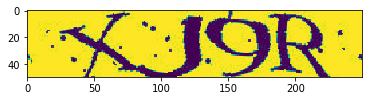

In [0]:
#REAL CAPCHA SET
batch_x_real=[obj.openImg("/content/drive/My Drive/micpi/pps/img/captcha%i.bmp"%i)[0] for i in range(384)]
batch_x_real=np.array(batch_x_real)

label_real=np.array(['XJ9R','4BDH','NDHN','YJPT','WNNR','J6BT','EC6B','U3BD','V94D','W9YV',
                     'AD4J','NENA','MXKP','UK6R','VWEY','EJD3','CP4J','J3T4','WWJ9','4RNT',
                     'PKPA','8HCP','V6HD','4PUU','RAUK','EE69','YMT6','MWU9','98XW','BMBY',
                     '6EYK','94NU','JMD6','4R9E','PNUX','9Y4A','JXAW','V8PU','YN4B','M43V',
                     'YURJ','EJ4J','XRCN','H3CW','6PH6','3YRB','RXWD','H4VH','R4R6','9PND',
                     '69H3','ENY9','VHM4','E4YC','6MRX','8TUN','4MXT','3TYR','9WNE','3PUM',
                     'UXKR','KBWK','UPX6','E8TV','N9WT','HTUE','HJYH','EXWT','PMUV','CK8E',
                     'C6NR','8A8A','WXMX','3VRY','NC3N','6KJV','VY8K','VWDH','TARX','W8XJ',
                     'RH8X','4BKW','TBH6','433M','JKPA','BMA4','A8U8','VDCA','6NN9','8CYJ',
                     '8B8D','YTHM','YU6R','W3B9','4KKE','VC4T','EKBR','3PC4','H4X9','6XCP',
                     '9B3J','WW38','4UCR','WVCD','ATTK','W4NV','HAK6','VWT9','69WC','HTHC',
                     'A3MA','BXHW','649T','RYMN','B36P','YP3H','T8AJ','TENH','8YEN','KUDH',
                     'YXDV','D9BB','4RPW','HVJX','PA43','8TRH','ACRH','PBDY','8KDE','E9WJ',
                     '4KKJ','X4DD','6P6T','HVTW','9P9A','AUB9','KRKV','PUNU','NCVA','MKW6',
                     'CHJK','438U','BTBB','RNTK','JTRT','RC3X','V6WT','KRCW','TJEB','EYVC',
                     '4AJM','XJKT','PW48','CY9J','NV3U','TU9V','98BN','8N9H','AM49','RWJY',
                     'WY3K','XXWA','PWHH','UK38','WJAN','XXTD','VCXK','ER8M','6YEV','KCAX',
                     'JC8T','W8N8','BJKM','XJU4','8P6B','MB9E','KEDE','AWV3','U4NE','89HH',
                     'MH8R','HWBP','4CP9','9R9V','YJ6X','B6X6','T3HX','RKR3','9J4C','9X4R',
                     'RXA6','3W83','R938','9T93','KNUA','MUVH','EVMW','3699','39XH','8DDR',
                     '3XHY','RU6U','WEAC','HT3B','W3C8','WKNX','JYJW','89WX','TKJR','TX93',
                     'BWUC','H6V3','DA9W','84KR','8DDM','J6W4','9BA4','NBX9','Y6DB','34BM',
                     '8EXK','UTWU','V4JY','NUYJ','YA9D','TY9X','4M9E','D9HK','PT44','A84X',
                     'XWAN','PDPK','NYAJ','A9YP','VCJW','BD9B','JNV4','RBB4','9XWH','6M8W',
                     '6MUR','NBM4','N4HK','PAXM','3C8A','D9JT','BJTK','DXC3','B6CJ','4TJ4',
                     'N868','6JWV','NY4A','CRPU','M346','KHB6','M938','U4UN','KTTU','KEBN',
                     '68XH','HJXD','TRJH','P99N','DYK8','KC4J','YHXA','ARXP','TDA9','N86X',
                     'DP4W','3P8A','UM3V','NBK4','4PXV','6NWR','PAK4','RJX8','TB6M','649H',
                     'H6M6','U3UD','8MR4','XRXN','DUV6','N38Y','B6Y4','AAWH','HT6A','J6RP',
                     'EBMK','HBNJ','YCP8','JAPC','JK8V','HHAD','XRV8','MD3P','A6BW','3866',
                     'YVD9','T946','9VKT','9AD3','6YYP','PB8V','KMUR','NRAP','YRWD','8UWM',
                     'XRPK','UDBB','494Y','NRAJ','38N8','TYXN','EHTN','KRR4','UCXN','3MTP',
                     'KRVC','TCD4','VD8W','B9T3','E399','6XUN','PJ3V','4RD4','JHW3','Y8PE',
                     'CTWW','TJPH','EXEU','HKDW','WTX9','UD6Y','RDB3','NKVA','U3MX','MHRY',
                     '6T3J','E9XN','YX3J','JTN8','PXW3','WKP3','PA6T','PCKC','DV6X','X6XR',
                     'C69Y','DYTC','DKJJ','YKD6','VM39','4UCV','63UM','88AP','EB34','U3VM',
                     'J3DE','3UK8','4XXR','K36Y','V63T','H4N9','4EEN','XD9N','U4RV','ACW4',
                     'JM4X','AET3','8A3B','DEAU','PX6A','EPNC','9VJA','8VDW','DRTD','HYTR',
                     'ARKJ','3XJK','UHW3','W4VJ',])

batch_y_real=[obj.text2vec(text) for text in label_real]

plt.imshow(batch_x_real[0].reshape([obj.IMAGE_HEIGHT,obj.IMAGE_WIDTH]))
plt.show()

In [0]:
training_set_no = 256

#separate training and validation set
batch_x_test2 =batch_x_real[training_set_no:]
batch_y_test2 =batch_y_real[training_set_no:]
batch_x_train2 =batch_x_real[:training_set_no]
batch_y_train2 =batch_y_real[:training_set_no]

def batch_combine(batch_x, batch_y, batch_x_train2, batch_y_train2):
  half_batch_size=len(batch_x)
  random_list = [i for i in range(len(batch_x_train2))]
  random.shuffle(random_list)
  for i in random_list[:half_batch_size]:
    batch_x = np.append(batch_x, [batch_x_train2[i]], axis=0)
    batch_y = np.append(batch_y, [batch_y_train2[i]], axis=0)
  
  random_list = [i for i in range(len(batch_y))]
  random.shuffle(random_list)
  batch_x=batch_x[random_list,:]
  batch_y=np.array(batch_y)[random_list,:].tolist()
  return batch_x, batch_y

## 4.CNN model
There are in total 78 layers, 5 downsampling layers which in total by a factor of 32, followed by 2 full connected layers.

Within each downsampling layers, 2 to 8 residual blocks with kernel_size 1x1,3x3,1x1 are added in order to carry the detail features along to a deeper layer.

leaky_relu is used to prevent “dying ReLU” problem. 

Batch normalization but no dropout is used after conv layer, as it brings significant improvements in convergence while preventing overfitting.



In [0]:
#image size
IMAGE_HEIGHT = obj.IMAGE_HEIGHT
IMAGE_WIDTH = obj.IMAGE_WIDTH
MAX_CAPTCHA = obj.max_size
CHAR_SET_LEN = obj.len

#model setting
_BATCH_NORM_DECAY =0.9
_BATCH_NORM_EPSILON =1e-5
_LEAKY_RELU = 0.1
####################################################################
X = tf.placeholder(tf.float32, [None, IMAGE_HEIGHT*IMAGE_WIDTH], name='X')
Y = tf.placeholder(tf.float32, [None, MAX_CAPTCHA*CHAR_SET_LEN],name='Y')
keep_prob = tf.placeholder(tf.float32, name='keep_prob') # dropout
train_phase = tf.placeholder(tf.bool,name='train_phase')

def batch_norm_next(x, training):
    """Performs a batch normalization using a standard set of parameters."""
    return tf.layers.batch_normalization(
        inputs=inputs, axis= -1,
        momentum=_BATCH_NORM_DECAY, epsilon=_BATCH_NORM_EPSILON,
        scale=True, training=training)

def fixed_padding(inputs, kernel_size):
    """ResNet implementation of fixed padding.

    Pads the input along the spatial dimensions independently of input size.

    Args:
        inputs: Tensor input to be padded.
        kernel_size: The kernel to be used in the conv2d or max_pool2d.
    Returns:
        A tensor with the same format as the input.
    """
    pad_total = kernel_size - 1
    pad_beg = pad_total // 2
    pad_end = pad_total - pad_beg
    padded_inputs = tf.pad(inputs, [[0, 0], [pad_beg, pad_end],
                                        [pad_beg, pad_end], [0, 0]])
    return padded_inputs


def conv2d_fixed_padding(inputs, filters, kernel_size, strides=1):
    """Strided 2-D convolution with explicit padding."""
    if strides > 1:
        inputs = fixed_padding(inputs, kernel_size)

    return tf.layers.conv2d(
        inputs=inputs, filters=filters, kernel_size=kernel_size,
        strides=strides, padding=('SAME' if strides == 1 else 'VALID'),
        use_bias=False)

def batch_norm(x, beta, gamma, phase_train, scope='bn', decay=0.9, eps=1e-5):
	with tf.variable_scope(scope):
		batch_mean, batch_var = tf.nn.moments(x, [0, 1, 2], name='moments')
		ema = tf.train.ExponentialMovingAverage(decay=decay)

		def mean_var_with_update():
			ema_apply_op = ema.apply([batch_mean, batch_var])
			with tf.control_dependencies([ema_apply_op]):
				return tf.identity(batch_mean), tf.identity(batch_var)

		mean, var = tf.cond(phase_train, mean_var_with_update, lambda: (ema.average(batch_mean), ema.average(batch_var)))
		normed = tf.nn.batch_normalization(x, mean, var, beta, gamma, eps)
	return normed
 
def conv_block( inputs, filters=64, kernel_size=3, scope='bn'):
	inputs = conv2d_fixed_padding(inputs, filters=filters, kernel_size=3,)
	inputs = batch_norm(inputs, tf.constant(0.0, shape=[filters]), tf.random_normal(shape=[filters], mean=1.0, stddev=0.02), train_phase, scope=scope)
	inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)
 
	inputs = conv2d_fixed_padding(inputs, filters=filters, kernel_size=3, strides=2)
	inputs = batch_norm(inputs, tf.constant(0.0, shape=[filters]), tf.random_normal(shape=[filters], mean=1.0, stddev=0.02), train_phase, scope=scope+'_1')
	inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)
	return inputs
 
def residual_block(inputs, filters=64, strides=1, scope='bn'):
    """Creates a residual block"""
    shortcut = inputs

    inputs = conv2d_fixed_padding(inputs, filters=filters, kernel_size=1, strides=strides,)
    inputs = batch_norm(inputs, tf.constant(0.0, shape=[filters]), tf.random_normal(shape=[filters], mean=1.0, stddev=0.02), train_phase, scope=scope)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    inputs = conv2d_fixed_padding(inputs, filters=filters, kernel_size=3, strides=strides,)
    inputs = batch_norm(inputs, tf.constant(0.0, shape=[filters]), tf.random_normal(shape=[filters], mean=1.0, stddev=0.02), train_phase, scope=scope+'_1')
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)
		
    inputs = conv2d_fixed_padding(inputs, filters= 2 * filters, kernel_size=1, strides=strides,)
    inputs = batch_norm(inputs, tf.constant(0.0, shape=[2 * filters]), tf.random_normal(shape=[2 * filters], mean=1.0, stddev=0.02), train_phase, scope=scope+'_2')
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)
    
    inputs += shortcut

    return inputs

# define CNN
def crack_captcha_cnn(w_alpha=0.01, b_alpha=0.1):
	x = tf.reshape(X, shape=[-1, IMAGE_HEIGHT, IMAGE_WIDTH, 1])
 
	inputs = conv_block(x, filters=64, kernel_size=3, scope='bn_1')
	for i in range(2):
		inputs = residual_block(inputs, filters=32, scope='rbn_1'+str(i))
	
	inputs = conv_block(inputs, filters=64, kernel_size=3, scope='bn_2')
	for i in range(8):
		inputs = residual_block(inputs, filters=32, scope='rbn_2'+str(i))
	
	inputs = conv_block(inputs, filters=64, kernel_size=3, scope='bn_3')
	for i in range(8):
		inputs = residual_block(inputs, filters=32, scope='rbn_3'+str(i))
	
	inputs = conv_block(inputs, filters=64, kernel_size=3, scope='bn_4')
	for i in range(4):
		inputs = residual_block(inputs, filters=32, scope='rbn_4'+str(i))
	
	inputs = conv_block(inputs, filters=64, kernel_size=3, scope='bn_5')
	
	[N,H,W,C]=inputs.shape
	total_nodes=H*W*C

	#detection layer
	#inputs = tf.layers.conv2d(inputs, filters=MAX_CAPTCHA*CHAR_SET_LEN, kernel_size=1,use_bias=True)
	
	
	# Fully connected layer
	w_d1 = tf.Variable(w_alpha*tf.random_normal([total_nodes, 2048]))
	b_d1 = tf.Variable(b_alpha*tf.random_normal([2048]))
	dense1 = tf.reshape(inputs, [-1, w_d1.get_shape().as_list()[0]])
	dense1 = tf.nn.leaky_relu(tf.add(tf.matmul(dense1, w_d1), b_d1), alpha=_LEAKY_RELU)
	dense1 = tf.nn.dropout(dense1, keep_prob)
 
	w_d2 = tf.Variable(w_alpha*tf.random_normal([2048, 1024]))
	b_d2 = tf.Variable(b_alpha*tf.random_normal([1024]))
	dense2 = tf.reshape(dense1, [-1, w_d2.get_shape().as_list()[0]])
	dense2 = tf.nn.leaky_relu(tf.add(tf.matmul(dense2, w_d2), b_d2), alpha=_LEAKY_RELU)
	dense2 = tf.nn.dropout(dense2, keep_prob)
 
	w_out = tf.Variable(w_alpha*tf.random_normal([1024, MAX_CAPTCHA*CHAR_SET_LEN]))
	b_out = tf.Variable(b_alpha*tf.random_normal([MAX_CAPTCHA*CHAR_SET_LEN]))
	out = tf.add(tf.matmul(dense2, w_out), b_out)
	
	return out

## 5. Training
This is a multi-class-multi-label classification problem, so "one vs all" strategy is used.
The model was trained with AdamOptimizer and sigmoid_cross_entropy_with_logits as a loss function.

In [0]:
def train_crack_captcha_cnn():
	output = crack_captcha_cnn()
	# loss
	loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=output, labels=Y))

	optimizer = tf.train.AdamOptimizer(learning_rate=0.002).minimize(loss)
 
	max_idx_p = tf.argmax(tf.reshape(output, [-1, MAX_CAPTCHA, CHAR_SET_LEN]), 2,name='max_idx_p')
	max_idx_l = tf.argmax(tf.reshape(Y, [-1, MAX_CAPTCHA, CHAR_SET_LEN]), 2,name='max_idx_l')
	correct_pred = tf.equal(max_idx_p, max_idx_l,name='correct_pred')
	#accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32),name='accuracy')                    #(word by word)
	accuracy = tf.reduce_mean(tf.cast(tf.reduce_all(correct_pred,1),tf.float32),name='accuracy')     #(img by img)
 

	saver = tf.train.Saver()
	with tf.Session() as sess:
		sess.run(tf.global_variables_initializer())
 
		step = 0
		while True:
			batch_x, batch_y = obj.get_next_batch(128)
			batch_x, batch_y = batch_combine(batch_x, batch_y, batch_x_train2, batch_y_train2)
			_, loss_ = sess.run([optimizer, loss], feed_dict={X: batch_x, Y: batch_y, keep_prob: 0.5, train_phase:True})
			print(step, loss_)

			#calculate the training accuracy
			if step % 10 == 0 and step != 0:
				#test1
				batch_x_test, batch_y_test = obj.get_next_batch(128)
				acc = sess.run(accuracy, feed_dict={X: batch_x_test, Y: batch_y_test, keep_prob: 1., train_phase:False})
				#test2
				acc2 = sess.run(accuracy, feed_dict={X: batch_x_test2, Y: batch_y_test2, keep_prob: 1., train_phase:False})
				print("the %s step，acc：%s,%s" % (step, acc, acc2))
				# end the training
				if acc2 > 0.9:
					saver.save(sess, "/content/drive/My Drive/Colab Notebooks/OCR/pps/history/pps0.99acc/pps.model", global_step=step)
					break
			step += 1


## 6. Get predict
define predict method

In [0]:
def gen_predict(batch_x_test,checkpoint_path,graph_path):
  image=batch_x_test[0].reshape([obj.IMAGE_HEIGHT,obj.IMAGE_WIDTH])
  #print(image.shape)
  f = plt.figure()
  ax = f.add_subplot(111)
  plt.imshow(image)  
  plt.show()

  with tf.Session() as sess:
      new_saver = tf.train.import_meta_graph(graph_path)
      new_saver.restore(sess, tf.train.latest_checkpoint(checkpoint_path))

      graph = tf.get_default_graph()
      max_idx_p = graph.get_tensor_by_name("max_idx_p:0")
      X = graph.get_tensor_by_name("X:0")
      keep_prob = graph.get_tensor_by_name("keep_prob:0")
      train_phase = graph.get_tensor_by_name("train_phase:0")
      predict=sess.run([max_idx_p], feed_dict={X: batch_x_test, keep_prob: 1., train_phase:False})

  predict = np.array([obj.vec2text(predict[0].tolist()[i]) for i in range(len(predict[0].tolist()))])
  print(predict[0])
  acc = np.sum(np.char.equal(predict, label_real[256:384]))/128
  print(acc)

## Toggle

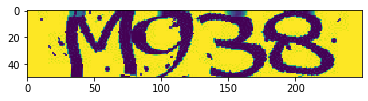

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Colab Notebooks/OCR/pps/history/pps0.99acc/pps.model-280
W938
0.8984375


In [0]:
train =0

#train
if train == 1:
  train_crack_captcha_cnn()    
  
#predict
if train ==0:
  tf.reset_default_graph()                 
  #tf.Graph()
  #i = random.randint(256,383)
  #batch_x_test=obj.openImg("/content/drive/My Drive/micpi/pps/img/captcha%i.bmp"%i)
  batch_x_test=[obj.openImg("/content/drive/My Drive/micpi/pps/img/captcha%i.bmp"%i)[0] for i in range(256,384)]
  #batch_x_test=obj.openImg("/content/drive/My Drive/Colab Notebooks/HTR/untitled folder/testing.bmp")
  #batch_x_test,_ = obj.get_next_batch(1)
  gen_predict(batch_x_test, '/content/drive/My Drive/Colab Notebooks/OCR/pps/history/pps0.99acc', '/content/drive/My Drive/Colab Notebooks/OCR/pps/history/pps0.99acc/pps.model-280.meta')

## Remark



CNN:
5,5,32
5,5,64
3,3,128
3,3,256
3,3,512

DENSE:
1024
1024

LOSS:sigmoid_cross_entropy_with_logits
OP: Adam (lr:0.002)
Result:(9000) 0.9

CONV BLOCK 64 *5
第260步，训练准确率为：0.92578125,0.52734375   (BY WORDS)

conv block 64 *5
residual block 32 2,8,8,4
DROPOUT 0.7
第390步，训练准确率为：0.99609375,0.65625      (by words)

ADD 64 MORE REAL SAMPLE INTO TRAINING TOTAL 128
第430步，训练准确率为：0.9902344,0.8964844      (BY WORDS)

REAL SAMPLE TOTAL 256
第450步，训练准确率为：0.9921875,0.8828125     (BY IMG)

# Appendix
image from website and image generated comparization

real:
real str: (50, 250)
[[ 0.72345959  0.72345959  0.72345959 ...  0.72345959  0.72345959
   0.72345959]
 [ 0.72345959  0.72345959  0.72345959 ...  0.72345959  0.72345959
   0.72345959]
 [ 0.72345959  0.72345959  0.72345959 ...  0.72345959  0.72345959
   0.72345959]
 ...
 [ 0.72345959  0.72345959  0.72345959 ... -1.03368588  0.51468983
   0.51468983]
 [ 0.72345959  0.72345959  0.72345959 ... -1.4947191  -1.4512254
  -1.4512254 ]
 [ 0.72345959  0.72345959  0.72345959 ... -0.85971108 -0.45956904
  -0.45956904]]
max: 0.7234595869109534 min: -1.494719097740764


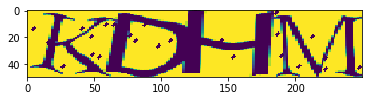

saved version
saved str: (50, 250)
[[0.6905547  0.6905547  0.6905547  ... 0.6905547  0.6905547  0.6905547 ]
 [0.6905547  0.6905547  0.6905547  ... 0.6905547  0.6905547  0.6905547 ]
 [0.6905547  0.6905547  0.6905547  ... 0.6905547  0.6905547  0.6905547 ]
 ...
 [0.6905547  0.6905547  0.6905547  ... 0.65423796 0.6905547  0.6905547 ]
 [0.6905547  0.6905547  0.6905547  ... 0.6905547  0.6905547  0.6905547 ]
 [0.6905547  0.6905547  0.6905547  ... 0.6905547  0.6905547  0.6905547 ]]
max: 0.6905546979845945 min: -1.6246370631884453


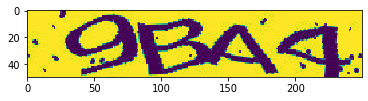

In [0]:
def _TEST():
  #real
  print('real:')
  batch_x,_ = obj.get_next_batch(1)
  image=batch_x[0].reshape([obj.IMAGE_HEIGHT,obj.IMAGE_WIDTH])
  print('real str:', image.shape)
  print(image)
  print('max:',np.max(image),'min:',np.min(image))
  f = plt.figure()
  ax = f.add_subplot(111)
  plt.imshow(image)  
  plt.show()
  im.imsave('testing.bmp', image)

  #saved version
  print('saved version')
  i = 216 #int(random.randint(0, 127))
  batch_x_saved=obj.openImg("/content/drive/My Drive/micpi/pps/img/captcha%i.bmp"%i)
  image_saved=batch_x_saved[0].reshape([obj.IMAGE_HEIGHT,obj.IMAGE_WIDTH])
  print('saved str:', image_saved.shape)
  print(image_saved)
  print('max:',np.max(image_saved),'min:',np.min(image_saved))
  f = plt.figure()
  ax = f.add_subplot(111)
  plt.imshow(image_saved)  
  plt.show()

_TEST()